In [1]:
# ════════════════════════════════════════════════════════════════════
# CELLULE 1 : Imports et Configuration
# ════════════════════════════════════════════════════════════════════

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Imports OK")

✅ Imports OK


In [11]:
# ════════════════════════════════════════════════════════════════════
# CELLULE 2 : Chargement des Données
# ════════════════════════════════════════════════════════════════════

# Charger les données
weather_scores = pd.read_csv('../data/processed/city_weather_scores.csv')
top5 = pd.read_csv('../data/processed/top5_destinations.csv')
hotels = pd.read_csv('../data/raw/hotels_top5_all.csv')

print("📊 DONNÉES CHARGÉES\n")
print(f"Villes avec scores météo : {len(weather_scores)}")
print(f"Top 5 destinations : {len(top5)}")
print(f"Hôtels récupérés : {len(hotels)}")
print(f"\nVilles dans hotels : {sorted(hotels['city'].unique())}")
print(f"Villes dans top5 : {sorted(top5['city'].unique())}")

print("\n🔍 Aperçu météo :")
# Utiliser les VRAIS noms de colonnes
display(top5[['city', 'avg_weather_score', 'temp_avg']].head())

print("\n🔍 Aperçu hôtels :")
display(hotels[['city', 'hotel_name', 'score', 'price']].head())

📊 DONNÉES CHARGÉES

Villes avec scores météo : 35
Top 5 destinations : 5
Hôtels récupérés : 75

Villes dans hotels : ['Aix en Provence', 'Avignon', 'Bormes les Mimosas', 'Cassis', 'Marseille']
Villes dans top5 : ['Aix en Provence', 'Avignon', 'Bormes les Mimosas', 'Cassis', 'Marseille']

🔍 Aperçu météo :


,city,avg_weather_score,temp_avg
0,Aix en Provence,76.33,13.0
1,Marseille,76.17,15.1
2,Bormes les Mimosas,76.00,13.0
3,Cassis,73.67,14.3
4,Avignon,71.83,12.9



🔍 Aperçu hôtels :


,city,hotel_name,score,price
0,Aix en Provence,Aparthotel Adagio Aix-en-Provence Centre,8.5,221.0
1,Aix en Provence,Best Western Hotel le Galice Aix-en-Provence,8.0,233.0
2,Aix en Provence,B&B HOTEL Aix-en-Provence Pont de l'Arc,7.5,128.0
3,Aix en Provence,Villa Saint-Ange,9.3,752.0
4,Aix en Provence,Le Concorde,8.0,260.0


In [12]:
# ════════════════════════════════════════════════════════════════════
# CELLULE 3 : Préparation des Données Hôtels
# ════════════════════════════════════════════════════════════════════

print("🧹 PRÉPARATION DES HÔTELS\n")
print("="*60)

# Statistiques par ville
hotels_by_city = hotels.groupby('city').agg({
    'hotel_name': 'count',
    'score': 'mean',
    'price': 'mean',
    'latitude': lambda x: x.notna().sum()
}).round(2)

hotels_by_city.columns = ['nb_hotels', 'avg_score', 'avg_price', 'with_gps']

print("\n📍 Hôtels par ville :")
print(hotels_by_city)

# Normaliser les noms de villes pour le merge
hotels['city_normalized'] = hotels['city'].str.strip().str.title()
top5['city_normalized'] = top5['city'].str.strip().str.title()

print("\n✅ Normalisation des noms de villes terminée")

🧹 PRÉPARATION DES HÔTELS


📍 Hôtels par ville :
                    nb_hotels  avg_score  avg_price  with_gps
city                                                         
Aix en Provence            15       8.54     292.53        15
Avignon                    15       8.63     257.00        15
Bormes les Mimosas         15       8.11     445.21        15
Cassis                     15       8.09     372.73        15
Marseille                  15       8.29     285.53        15

✅ Normalisation des noms de villes terminée


In [13]:
# ════════════════════════════════════════════════════════════════════
# CELLULE 4 : Fusion des Données
# ════════════════════════════════════════════════════════════════════

print("\n🔗 FUSION DES DONNÉES\n")
print("="*60)

# Merger avec les VRAIS noms de colonnes
hotels_with_weather = hotels.merge(
    top5[['city_normalized', 'avg_weather_score', 'temp_avg', 'rain', 'clouds']],
    on='city_normalized',
    how='left'
)

print(f"✅ Fusion réussie : {len(hotels_with_weather)} hôtels")

# Vérifier les valeurs manquantes
missing_weather = hotels_with_weather['avg_weather_score'].isna().sum()
if missing_weather > 0:
    print(f"⚠️  {missing_weather} hôtels sans score météo")
    print("Villes concernées :")
    print(hotels_with_weather[hotels_with_weather['avg_weather_score'].isna()]['city'].unique())
else:
    print("✅ Tous les hôtels ont un score météo")


🔗 FUSION DES DONNÉES

✅ Fusion réussie : 75 hôtels
✅ Tous les hôtels ont un score météo


In [14]:
# ════════════════════════════════════════════════════════════════════
# CELLULE 5 : Création du Score Final
# ════════════════════════════════════════════════════════════════════

print("\n🎯 CALCUL DU SCORE FINAL\n")
print("="*60)

# Normaliser sur 0-10
def normalize_score(series, higher_is_better=True):
    """Normalise une série sur 0-10."""
    if series.isna().all():
        return series
    
    min_val = series.min()
    max_val = series.max()
    
    if min_val == max_val:
        return pd.Series([5.0] * len(series), index=series.index)
    
    if higher_is_better:
        return 10 * (series - min_val) / (max_val - min_val)
    else:
        return 10 * (max_val - series) / (max_val - min_val)


# Normaliser les dimensions (AVEC LES VRAIS NOMS)
hotels_with_weather['weather_score_norm'] = normalize_score(
    hotels_with_weather['avg_weather_score'], 
    higher_is_better=True
)

hotels_with_weather['hotel_score_norm'] = normalize_score(
    hotels_with_weather['score'], 
    higher_is_better=True
)

hotels_with_weather['price_score_norm'] = normalize_score(
    hotels_with_weather['price'], 
    higher_is_better=False
)

# Score final : 40% météo, 40% qualité, 20% prix
hotels_with_weather['final_score'] = (
    0.40 * hotels_with_weather['weather_score_norm'] +
    0.40 * hotels_with_weather['hotel_score_norm'] +
    0.20 * hotels_with_weather['price_score_norm']
)

print("✅ Scores calculés")
print("\n📊 Distribution des scores :")
print(hotels_with_weather['final_score'].describe())


🎯 CALCUL DU SCORE FINAL

✅ Scores calculés

📊 Distribution des scores :
count    74.000000
mean      7.795927
std       1.743271
min       1.723247
25%       6.830953
50%       8.846027
75%       9.151384
max       9.863708
Name: final_score, dtype: float64


In [15]:
# ════════════════════════════════════════════════════════════════════
# CELLULE 6 : Classement et Recommandations
# ════════════════════════════════════════════════════════════════════

print("\n🏆 TOP 10 RECOMMANDATIONS GLOBALES\n")
print("="*80)

# Filtrer données complètes
complete_data = hotels_with_weather.dropna(subset=['final_score', 'score', 'price'])

# Top 10 global (AVEC LES VRAIS NOMS)
top10_global = complete_data.nlargest(10, 'final_score')[[
    'city', 'hotel_name', 'score', 'price', 
    'avg_weather_score', 'final_score'  # ✅ Changé de 'combined_score'
]].round(2)

top10_global.index = range(1, len(top10_global) + 1)
print(top10_global)

print("\n\n🌟 TOP 3 PAR VILLE\n")
print("="*80)

for city in complete_data['city'].unique():
    city_hotels = complete_data[complete_data['city'] == city].nlargest(3, 'final_score')
    
    print(f"\n📍 {city.upper()}")
    print(f"   Score météo : {city_hotels['avg_weather_score'].iloc[0]:.2f}")  # ✅ Changé
    print(f"   Température : {city_hotels['temp_avg'].iloc[0]:.1f}°C")  # ✅ Changé
    print(f"   {'─'*60}")
    
    for idx, hotel in city_hotels.iterrows():
        print(f"   {hotel['hotel_name'][:45]:45s} | "
              f"Score: {hotel['score']:.1f}/10 | "
              f"Prix: {hotel['price']:.0f}€ | "
              f"Final: {hotel['final_score']:.2f}")


🏆 TOP 10 RECOMMANDATIONS GLOBALES

                  city                                         hotel_name  \
1      Aix en Provence                                   La Villa Rustica   
2   Bormes les Mimosas  Le Mas de la Palmeraie - Studio dans propriété...   
3      Aix en Provence                          Les Suites du Cours & Spa   
4   Bormes les Mimosas                      La Favière proche de la plage   
5   Bormes les Mimosas                                Boulevard du Soleil   
6      Aix en Provence                             Domaine de Saint Clair   
7            Marseille                           RockyPop Marseille Hôtel   
8            Marseille            Loft 200m2 avec écran led géant de 10m2   
9      Aix en Provence                Terrasse & Spa dans Aix Hypercentre   
10  Bormes les Mimosas                         Romantic getaway in Bormes   

    score  price  avg_weather_score  final_score  
1     9.8  234.0              76.33         9.86  
2     9.7  198


📊 VISUALISATIONS

✅ Graphiques sauvegardés


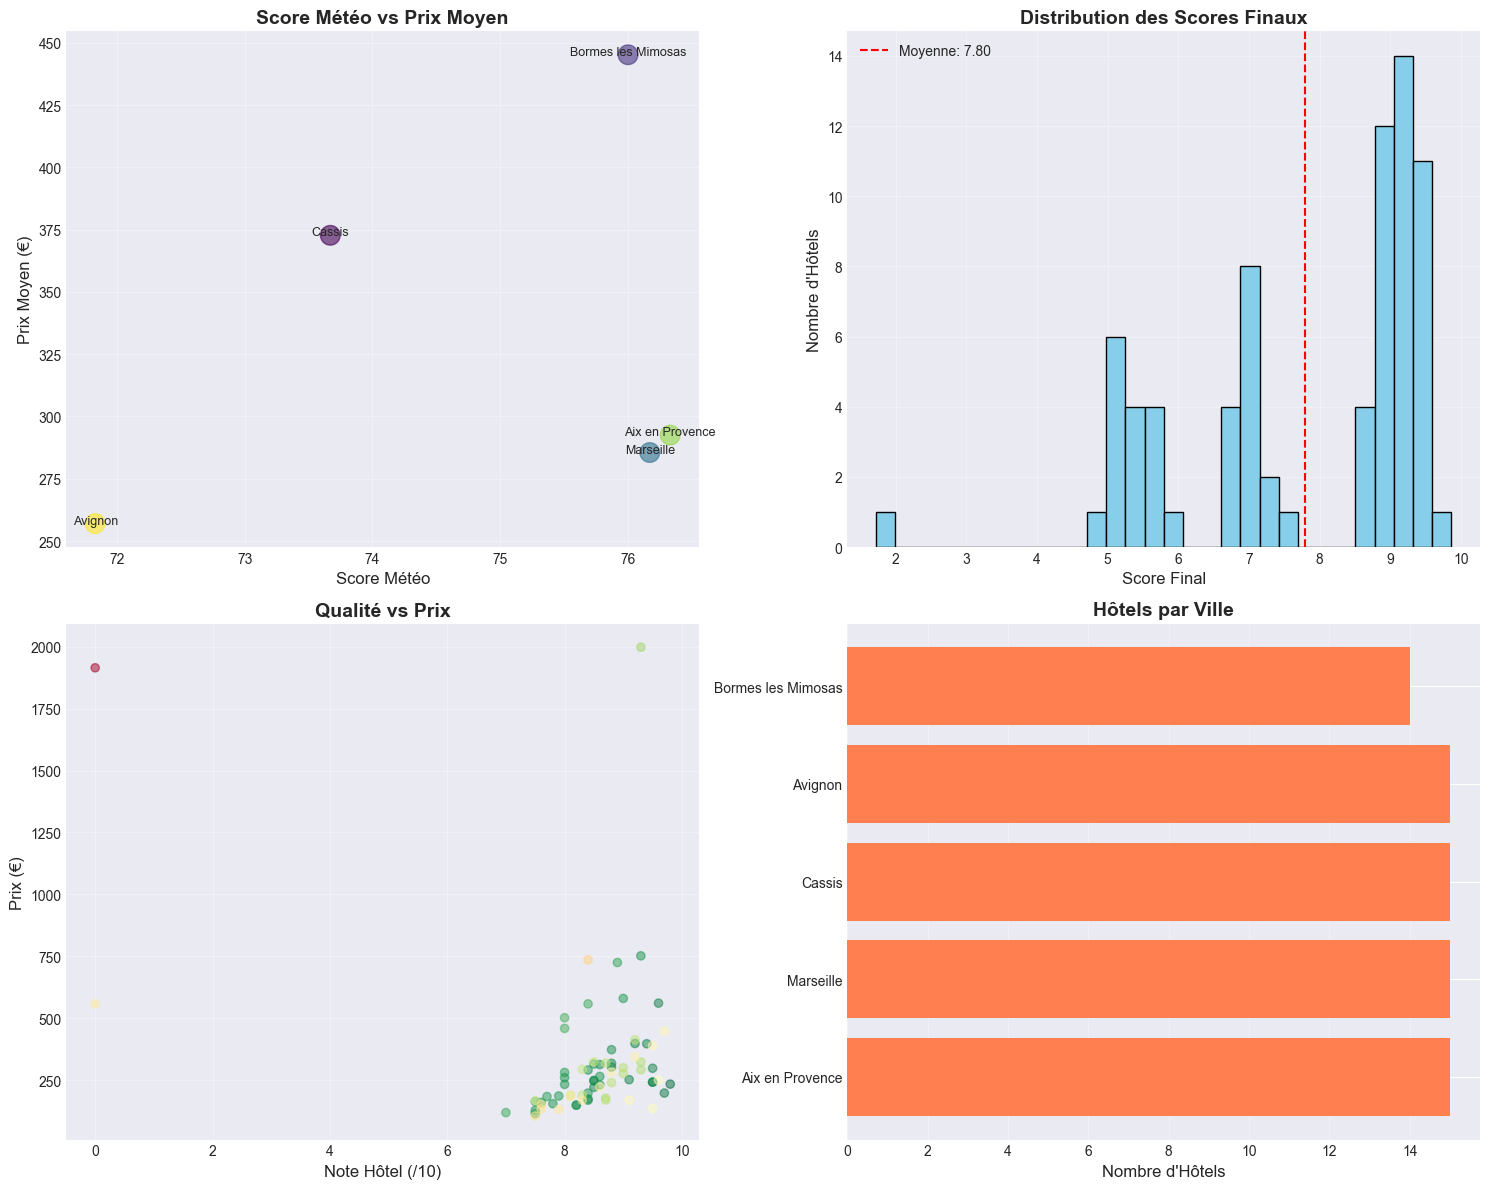

In [17]:
# ════════════════════════════════════════════════════════════════════
# CELLULE 7 : Visualisations
# ════════════════════════════════════════════════════════════════════

print("\n📊 VISUALISATIONS\n")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Stats par ville (AVEC VRAIS NOMS)
city_stats = complete_data.groupby('city').agg({
    'avg_weather_score': 'first',  # ✅ Changé
    'price': 'mean',
    'score': 'mean'
}).reset_index()

# Graph 1 : Score météo vs Prix
axes[0, 0].scatter(city_stats['avg_weather_score'], city_stats['price'],  # ✅ Changé
                   s=200, alpha=0.6, c=city_stats['score'], cmap='viridis')
for idx, row in city_stats.iterrows():
    axes[0, 0].annotate(row['city'], 
                        (row['avg_weather_score'], row['price']),  # ✅ Changé
                        fontsize=9, ha='center')
axes[0, 0].set_xlabel('Score Météo', fontsize=12)
axes[0, 0].set_ylabel('Prix Moyen (€)', fontsize=12)
axes[0, 0].set_title('Score Météo vs Prix Moyen', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Graph 2 : Distribution scores
axes[0, 1].hist(complete_data['final_score'], bins=30, color='skyblue', edgecolor='black')
axes[0, 1].axvline(complete_data['final_score'].mean(), color='red', 
                   linestyle='--', label=f'Moyenne: {complete_data["final_score"].mean():.2f}')
axes[0, 1].set_xlabel('Score Final', fontsize=12)
axes[0, 1].set_ylabel('Nombre d\'Hôtels', fontsize=12)
axes[0, 1].set_title('Distribution des Scores Finaux', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Graph 3 : Qualité vs Prix
axes[1, 0].scatter(complete_data['score'], complete_data['price'], 
                   alpha=0.5, c=complete_data['final_score'], cmap='RdYlGn')
axes[1, 0].set_xlabel('Note Hôtel (/10)', fontsize=12)
axes[1, 0].set_ylabel('Prix (€)', fontsize=12)
axes[1, 0].set_title('Qualité vs Prix', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Graph 4 : Hôtels par ville
city_counts = complete_data['city'].value_counts()
axes[1, 1].barh(city_counts.index, city_counts.values, color='coral')
axes[1, 1].set_xlabel('Nombre d\'Hôtels', fontsize=12)
axes[1, 1].set_title('Hôtels par Ville', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../data/processed/analysis_fusion.png', dpi=300, bbox_inches='tight')
print("✅ Graphiques sauvegardés")
plt.show()

In [20]:
# ════════════════════════════════════════════════════════════════════
# CELLULE 8 : Export
# ════════════════════════════════════════════════════════════════════

print("\n💾 EXPORT\n")
print("="*60)

# Sélectionner colonnes (AVEC VRAIS NOMS)
final_recommendations = hotels_with_weather[[
    'city', 'hotel_name', 'url', 'property_type',
    'score', 'number_of_reviews', 'price', 'currency',
    'latitude', 'longitude',
    'avg_weather_score', 'temp_avg', 'rain', 'clouds',  # ✅ Changé
    'weather_score_norm', 'hotel_score_norm', 'price_score_norm',
    'final_score',
    'facilities', 'image_url'
]].copy()

final_recommendations = final_recommendations.sort_values('final_score', ascending=False)
final_recommendations['rank'] = range(1, len(final_recommendations) + 1)

# Export
final_recommendations.to_csv('../data/processed/final_recommendations.csv', index=False)
print(f"✅ final_recommendations.csv ({len(final_recommendations)} hôtels)")

# Top 20
final_recommendations.head(20).to_csv('../data/processed/top20_recommendations.csv', index=False)
print(f"✅ top20_recommendations.csv")

print("\n📊 STATISTIQUES")
print(f"Villes : {final_recommendations['city'].nunique()}")
print(f"Hôtels : {len(final_recommendations)}")
print(f"Score moyen : {final_recommendations['final_score'].mean():.2f}")
print(f"Prix moyen : {final_recommendations['price'].mean():.0f}€")


💾 EXPORT

✅ final_recommendations.csv (75 hôtels)
✅ top20_recommendations.csv

📊 STATISTIQUES
Villes : 5
Hôtels : 75
Score moyen : 7.80
Prix moyen : 329€
